Notebook to compare different de-regularization methods

# Import

In [1]:
import os
import sys

fpth = os.path.abspath(os.path.join('..','RMWSPy', 'cml_example'))
sys.path.append(fpth)
fpth = os.path.abspath(os.path.join('..','RMWSPy', 'rmwspy'))
sys.path.append(fpth)

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from tqdm import tqdm
import string

import rain_data as cmlp
import RM_processing as rmp
from cml import *

%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns

In [3]:
erlend_pth = os.path.abspath(os.path.join('..','..'))
sys.path.append(erlend_pth)
from RM_processing import create_blocks_from_lines
from RM_processing import generate_cmls_grid_intersects

import gstools as gs
import pickle
# supress warnings from shapely
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [4]:
from skgstat import Variogram

In [5]:
%matplotlib inline

In [6]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [7]:
plt.style.use('seaborn-v0_8-paper')

# Lognormal transformed data

In [8]:
mu = -1
sigma = 0.76
field_lengths = np.array([5, 10, 15, 20]) # works up to 20... 
link_max_length = 30
link_lengths =  np.linspace(0.1, link_max_length, 12)  #7

In [27]:
grid_size = 50
field_length = 20
n_cml = 100
link_length = 0.1
margin = int(link_max_length)
x = np.arange(grid_size + 2*margin) # y coordinate
y = np.arange(grid_size + 2*margin) # x coordinate

hr_c = []
hr_v = []
for i in range(20):
    model = gs.Exponential(dim=2, var=1, len_scale=field_length)
    srf = gs.SRF(model, seed=1)
    field = np.zeros([1, y.size, x.size])
    field[0] = np.exp(srf.structured([y, x])*sigma + mu)
    
    [y_ind_a, y_ind_b], [x_ind_a, x_ind_b], radar_along_cmls = generate_cmls_grid_intersects(
                                        np.random.randint(0 + margin, x.size - margin, size=n_cml),
                                        np.random.randint(0 + margin, y.size - margin, size=n_cml),
                                        np.ones(n_cml)*link_length,
                                        field
                                    )
    # max allowed lengths
    x_ind = np.hstack([x_ind_a.reshape(-1, 1), x_ind_b.reshape(-1, 1)]).mean(axis = 1)
    y_ind = np.hstack([y_ind_a.reshape(-1, 1), y_ind_b.reshape(-1, 1)]).mean(axis = 1)
    #print(np.sqrt((x_ind - x_ind.reshape(-1, 1))**2 + (y_ind - y_ind.reshape(-1, 1))**2).max()/3)
    
    
    ds_cmls = da = xr.DataArray(
        data=radar_along_cmls[0],
        dims=["obs_id"],
        coords=dict(
            x=(["obs_id"], np.rint(((x_ind_a +  x_ind_b)/2))),
            y=(["obs_id"], np.rint(((y_ind_a +  y_ind_b)/2))),
            y_a=(["obs_id"], y_ind_a),
            y_b=(["obs_id"], y_ind_b),
            x_a=(["obs_id"], x_ind_a),
            x_b=(["obs_id"], x_ind_b),
        ),
    
    )
        
    ds_cmls = cmlp.label_combined_duplicates(ds_cmls)
    ds_cmls = ds_cmls.where(ds_cmls.label_dupl, drop=True)
    
    #copula midpoint estimation
    lin_yx = np.vstack((ds_cmls.y.values, ds_cmls.x.values)).T.astype(int)
    lin_prec = ds_cmls.values
    lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
    lin_prec *= 10.0
    cmod = rmp.calculate_copula( 
        lin_yx,
        lin_prec,
        outputfile=None,
        covmods='exp',
        ntries=6,
        nugget=0,
        maxrange = 600,
        minrange = 1,
    )
    hr_c.append(float(cmod.split()[-1][4:-1]))
    
    V = Variogram(
        np.hstack([lin_yx[:, 1].reshape(-1, 1), lin_yx[:, 0].reshape(-1, 1)]), 
        np.log(lin_prec), # log transform to make data more gaussian
        model='exponential', 
        use_nugget=False,
        fit_bounds = ((1, 0), (600, np.log(lin_prec).var()*2)),
    )
    hr, sill, nugget = V.parameters
    # print(field_length/3)
    hr_v.append(hr/3)

In [11]:
hr_copula_midpoint_ff = []
hr_copula_dereg_ff = []
hr_eshel_midpoint_ff = []
hr_eshel_dereg_ff = []
hr_true_ff = []

seed = 1 # new geometry for each run
np.random.seed(seed)
grid_sizes = [50, 100] # grid sizes to analyses
n_cmls = [10, 100] # number of cmls to analyse
time = np.arange(50) # number of realizations, stored along time dimension.. 25
margin = int(link_max_length)

for grid_size in grid_sizes:
    x = np.arange(grid_size + 2*margin) # y coordinate
    y = np.arange(grid_size + 2*margin) # x coordinate
    hr_copula_midpoint_f = []
    hr_copula_dereg_f = []
    hr_eshel_midpoint_f = []
    hr_eshel_dereg_f = []
    hr_true_f = []
    for field_length in field_lengths:
        bin_edges = np.linspace(0, field_length*3, 21)  # used for variogram fitting

        hr_copula_midpoint = []
        hr_copula_dereg = []
        hr_eshel_midpoint = []
        hr_eshel_dereg = []
        hr_true = []
        for n_cml in n_cmls:
            hr_copula_midpoint_ = []
            hr_copula_dereg_ = []
            hr_eshel_midpoint_ = []
            hr_eshel_dereg_ = []
            hr_true_ = []
            for link_length in tqdm(link_lengths): # start counting here
                field = np.zeros([time.size, y.size, x.size])
                # link length is from loop, same length all links, random midpoints
                for i in time:
                    seed += 1
                    model = gs.Exponential(dim=2, var=1, len_scale=field_length)
                    srf = gs.SRF(model, seed=seed)
                    field[i] = np.exp(srf.structured([y, x])*sigma + mu)

                [y_ind_a, y_ind_b], [x_ind_a, x_ind_b], radar_along_cmls = generate_cmls_grid_intersects(
                                                    np.random.randint(0 + margin, x.size - margin, size=n_cml),
                                                    np.random.randint(0 + margin, y.size - margin, size=n_cml),
                                                    np.ones(n_cml)*link_length,
                                                    field
                                                )

                hr_copula_midpoint__ = []
                hr_copula_dereg__ = []
                hr_eshel_midpoint__ = []
                hr_eshel_dereg__ = []
                
                # For through time
                for i in range(radar_along_cmls.shape[0]): 
                    # Prepare data for CML sampling
                    ds_cmls = da = xr.DataArray(
                        data=radar_along_cmls[i],
                        dims=["obs_id"],
                        coords=dict(
                            x=(["obs_id"], np.rint(((x_ind_a +  x_ind_b)/2))),
                            y=(["obs_id"], np.rint(((y_ind_a +  y_ind_b)/2))),
                            y_a=(["obs_id"], y_ind_a),
                            y_b=(["obs_id"], y_ind_b),
                            x_a=(["obs_id"], x_ind_a),
                            x_b=(["obs_id"], x_ind_b),
                        ),

                    )
                        
                    ds_cmls = cmlp.label_combined_duplicates(ds_cmls)
                    ds_cmls = ds_cmls.where(ds_cmls.label_dupl, drop=True)

                    # Method 1: Copula midpoint, normal point initialization
                    lin_yx = np.vstack((ds_cmls.y.values, ds_cmls.x.values)).T.astype(int)
                    lin_prec = ds_cmls.values
                    lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
                    lin_prec *= 10.0
                    cmod = rmp.calculate_copula( 
                        lin_yx,
                        lin_prec,
                        outputfile=None,
                        covmods='exp',
                        ntries=6,
                        nugget=0,
                        maxrange = 600,
                        minrange = 1,
                    )
                    res_mid_t = float(cmod.split()[-1][4:-1])
                    hr_copula_midpoint__.append([res_mid_t])#, res_g])

                    # Method 2: Copula deregularization
                    pos_x, pos_y = create_blocks_from_lines(np.hstack([
                        ds_cmls.y_a.values.reshape(-1, 1),
                        ds_cmls.y_b.values.reshape(-1, 1),
                        ds_cmls.x_a.values.reshape(-1, 1),
                        ds_cmls.x_b.values.reshape(-1, 1),
                    ]), disc =8) 
                    lin_yx = np.array([pos_y, pos_x]).transpose([1, 0, 2]) 

                    lin_prec = ds_cmls.values
                    lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
                    lin_prec *= 10.0
                    cmod = rmp.calculate_copula(
                        lin_yx,
                        lin_prec,
                        outputfile=None,
                        covmods='exp',
                        ntries=6,
                        nugget=0,
                        mode='block', # 
                        maxrange = res_mid_t,
                        minrange = 1,
                        
                    )       
                    res_t = float(cmod.split()[-1][4:-1])
                    hr_copula_dereg__.append([res_t]) 

                    # Method 3: Eshel 
                    lin_yx = np.vstack((ds_cmls.y.values, ds_cmls.x.values)).T.astype(int)
                    lin_prec = ds_cmls.values
                    lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
                    
                    V = Variogram(
                        np.hstack([lin_yx[:, 1].reshape(-1, 1), lin_yx[:, 0].reshape(-1, 1)]), 
                        np.log(lin_prec), # log transform to make data more gaussian
                        model='exponential', 
                        use_nugget=False,
                        bins=bin_edges,
                        fit_bounds = ((1, 0), (600, np.log(lin_prec).var()*2)),
                    )
                    hr, sill, nugget = V.parameters
                    hr = hr/3
                    
                    hr_eshel_midpoint__.append([hr])
                    L = link_length # Mean link length (in this experiment all links have the same length)
                    hr_eshel_dereg__.append([hr - 0.72*(1*L)**0.72]) # Eshel 22a
                    
                hr_copula_midpoint_.append(np.array(hr_copula_midpoint__))
                hr_copula_dereg_.append(np.array(hr_copula_dereg__))
                hr_eshel_midpoint_.append(np.array(hr_eshel_midpoint__))
                hr_eshel_dereg_.append(np.array(hr_eshel_dereg__))

            hr_copula_midpoint.append(np.array(hr_copula_midpoint_))
            hr_copula_dereg.append(np.array(hr_copula_dereg_))
            hr_eshel_midpoint.append(np.array(hr_eshel_midpoint_))
            hr_eshel_dereg.append(np.array(hr_eshel_dereg_))

        hr_copula_midpoint_f.append(np.array(hr_copula_midpoint))
        hr_copula_dereg_f.append(np.array(hr_copula_dereg))
        hr_eshel_midpoint_f.append(np.array(hr_eshel_midpoint))
        hr_eshel_dereg_f.append(np.array(hr_eshel_dereg))
    
    hr_copula_midpoint_ff.append(hr_copula_midpoint_f)
    hr_copula_dereg_ff.append(hr_copula_dereg_f)
    hr_eshel_midpoint_ff.append(np.array(hr_eshel_midpoint_f))
    hr_eshel_dereg_ff.append(np.array(hr_eshel_dereg_f))

hr_copula_dereg_ff = np.array(hr_copula_dereg_ff)
hr_copula_midpoint_ff = np.array(hr_copula_midpoint_ff)
hr_eshel_midpoint_ff = np.array(hr_eshel_midpoint_ff)
hr_eshel_dereg_ff = np.array(hr_eshel_dereg_ff)


100%|█| 12/12 [1:01:57<00:00, 309.77s/
100%|█| 12/12 [4:29:36<00:00, 1348.04s
100%|█| 12/12 [1:11:17<00:00, 356.45s/
100%|█| 12/12 [4:49:31<00:00, 1447.64s
100%|█| 12/12 [1:04:00<00:00, 320.01s/
100%|█| 12/12 [4:54:22<00:00, 1471.83s
100%|█| 12/12 [1:02:01<00:00, 310.12s/
100%|█| 12/12 [5:00:40<00:00, 1503.41s
100%|█| 12/12 [1:16:43<00:00, 383.64s/
100%|█| 12/12 [5:03:04<00:00, 1515.36s
100%|█| 12/12 [1:15:49<00:00, 379.08s/
100%|█| 12/12 [5:25:16<00:00, 1626.41s
100%|█| 12/12 [1:18:06<00:00, 390.57s/
100%|█| 12/12 [5:29:58<00:00, 1649.91s
100%|█| 12/12 [1:15:07<00:00, 375.62s/
100%|█| 12/12 [5:38:28<00:00, 1692.36s


In [12]:
# dump results to temporary folder for later reload:
fields = [hr_copula_dereg_ff, hr_copula_midpoint_ff, hr_eshel_midpoint_ff, hr_eshel_dereg_ff]
with open('/home/erlend/Downloads/field_synthetic1_var2.pickle', 'wb') as handle:
    pickle.dump(fields, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
with open(r'/home/erlend/Downloads/field_synthetic1_var2.pickle', "rb") as input_file: 
    [hr_copula_dereg_ff, hr_copula_midpoint_ff, hr_eshel_midpoint_ff, hr_eshel_dereg_ff] = pickle.load(input_file)

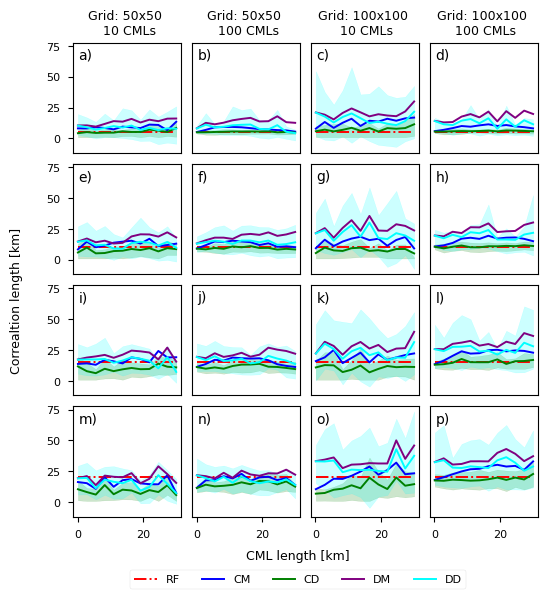

In [16]:
fig, ax = plt.subplots(hr_copula_dereg_ff.shape[1], 4, figsize=(6, 6), sharey = True)
ax[0, 0].set_title('Grid: 50x50 \n 10 CMLs', fontsize=9)
ax[0, 1].set_title('Grid: 50x50 \n 100 CMLs', fontsize=9)
ax[0, 2].set_title('Grid: 100x100 \n 10 CMLs', fontsize=9)
ax[0, 3].set_title('Grid: 100x100 \n 100 CMLs', fontsize=9)

#fig.supxlabel('CML length [km]', fontsize=9)
fig.supylabel('Correaltion length [km]', fontsize=9)

j = 0
for k in range(hr_copula_midpoint_ff.shape[1]): # for through field lengths 
    for i in range(hr_copula_midpoint_ff.shape[2]): # for through ncmls
        ax[k, i].plot(link_lengths, np.ones(link_lengths.shape)*field_lengths[k], '-.r', label = 'RF')
        # Copula Midpoint
        mean = np.mean(hr_copula_midpoint_ff[j, k, i, :, :, 0], axis = 1)
        min_ = np.quantile(hr_copula_midpoint_ff[j, k, i, :, :, 0], q = 0.2, axis = 1)
        max_ = np.quantile(hr_copula_midpoint_ff[j, k, i, :, :, 0], q = 0.8, axis = 1)
        ax[k, i].plot(link_lengths, mean, color = 'blue', label = 'CM')
        # ax[k, i].fill_between(link_lengths, min_, max_, color = 'blue', alpha=0.2)
        
        # Copula Dereg
        mean = np.mean(hr_copula_dereg_ff[j, k, i, :, :, 0], axis = 1)
        min_ = np.quantile(hr_copula_dereg_ff[j, k, i, :, :, 0], q = 0.2, axis = 1)
        max_ = np.quantile(hr_copula_dereg_ff[j, k, i, :, :, 0], q = 0.8, axis = 1)
        ax[k, i].plot(link_lengths, mean,  color = 'green', label = 'CD')
        ax[k, i].fill_between(link_lengths, min_, max_, color = 'green', alpha=0.2)

        # Eshel midpoint
        mean = np.mean(hr_eshel_midpoint_ff[j, k, i, :, :, 0], axis = 1)
        min_ = np.quantile(hr_eshel_midpoint_ff[j, k, i, :, :, 0], q = 0.2, axis = 1)
        max_ = np.quantile(hr_eshel_midpoint_ff[j, k, i, :, :, 0], q = 0.8, axis = 1)
        ax[k, i].plot(link_lengths, mean,  color = 'purple', label = 'DM')
        # ax[k, i].fill_between(link_lengths, min_, max_, color = 'purple', alpha=0.2)

        # Eshel dereg
        mean = np.mean(hr_eshel_dereg_ff[j, k, i, :, :, 0], axis = 1)
        min_ = np.quantile(hr_eshel_dereg_ff[j, k, i, :, :, 0], q = 0.2, axis = 1)
        max_ = np.quantile(hr_eshel_dereg_ff[j, k, i, :, :, 0], q = 0.8, axis = 1)
        ax[k, i].plot(link_lengths, mean,  color = 'cyan', label = 'DD')
        ax[k, i].fill_between(link_lengths, min_, max_, color = 'cyan', alpha=0.2)
        
j = 1
for k in range(hr_copula_midpoint_ff.shape[1]): # for through field lengths 
    for i in range(hr_copula_midpoint_ff.shape[2]): # for through ncmls
        ax[k, i+2].plot(link_lengths, np.ones(link_lengths.shape)*field_lengths[k], '-.r')

        # Copula midpoint
        mean = np.mean(hr_copula_midpoint_ff[j, k, i, :, :, 0], axis = 1)
        min_ = np.quantile(hr_copula_midpoint_ff[j, k, i, :, :, 0], q = 0.2, axis = 1)
        max_ = np.quantile(hr_copula_midpoint_ff[j, k, i, :, :, 0], q = 0.8, axis = 1)
        ax[k, i+2].plot(link_lengths, mean, color = 'blue', label = 'CM')
        # ax[k, i+2].fill_between(link_lengths, min_, max_, color = 'blue', alpha=0.2)

        # Copula dereg
        mean = np.mean(hr_copula_dereg_ff[j, k, i, :, :, 0], axis = 1)
        min_ = np.quantile(hr_copula_dereg_ff[j, k, i, :, :, 0], q = 0.2, axis = 1)
        max_ = np.quantile(hr_copula_dereg_ff[j, k, i, :, :, 0], q = 0.8, axis = 1)
        ax[k, i+2].plot(link_lengths, mean,  color = 'green', label = 'CD')
        ax[k, i+2].fill_between(link_lengths, min_, max_, color = 'green', alpha=0.2)
        
        # Eshel midpoint
        mean = np.mean(hr_eshel_midpoint_ff[j, k, i, :, :, 0], axis = 1)
        min_ = np.quantile(hr_eshel_midpoint_ff[j, k, i, :, :, 0], q = 0.2, axis = 1)
        max_ = np.quantile(hr_eshel_midpoint_ff[j, k, i, :, :, 0], q = 0.8, axis = 1)
        ax[k, i+2].plot(link_lengths, mean,  color = 'purple', label = 'DM')
        # ax[k, i+2].fill_between(link_lengths, min_, max_, color = 'purple', alpha=0.2)

        # Eshel dereg
        mean = np.mean(hr_eshel_dereg_ff[j, k, i, :, :, 0], axis = 1)
        min_ = np.quantile(hr_eshel_dereg_ff[j, k, i, :, :, 0], q = 0.2, axis = 1)
        max_ = np.quantile(hr_eshel_dereg_ff[j, k, i, :, :, 0], q = 0.8, axis = 1)
        ax[k, i+2].plot(link_lengths, mean,  color = 'cyan', label = 'DD')
        ax[k, i+2].fill_between(link_lengths, min_, max_, color = 'cyan', alpha=0.2)
        
# remove x-ticks
for k in range(hr_copula_midpoint_ff.shape[1] - 1): # for through field lengths 
    for i in range(4): # for through ncmls
        #ax[k, i].set_ylim(-10, 40)
        ax[k, i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off

# remove y-ticks
for k in range(hr_copula_midpoint_ff.shape[1]): # for through field lengths 
    for i in range(1,4): # for through ncmls
        ax[k, i].tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, axis = 'y', which='both')


handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.06), ncol=5)
#fig.supxlabel('CML length [km]', fontsize=9)
fig.text(0.5, 0.075, 'CML length [km]', ha='center', va='center', fontsize=9)
plt.subplots_adjust(bottom=0.14, top=0.93, wspace=0.1, hspace=0.1)  # Adjust as necessary

for i, ax_ in enumerate(ax.flatten()):
    label = string.ascii_lowercase[i]  # This will generate labels a, b, c, ...
    ax_.text(0.05, 0.85, label + ')', transform=ax_.transAxes, size=10) 

plt.savefig('/home/erlend/Downloads/range_synthetic.png', format = 'png', dpi=600)